In [1]:
# GPU VM

import numpy as np
import numpy as np
import matplotlib.pyplot as pyplot
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import os
import sys
import gc

In [2]:
# IMAGE PROCESSING

def getData():
    trainData = []
    alteredTrainData = []
    testData = []
    alteredTestData = []

    imgIndex = 1
    imageMax = 1000
    for filename in os.listdir("COIL-20/train"):
        img = Image.open("COIL-20/train/%s" % (filename,))
        imgTensor = torch.from_numpy(np.asarray(img))
        imgTensor = imgTensor.reshape(-1)
        imgTensor = imgTensor.float()
        imgTensor = torch.div(imgTensor, 127.5) - 1

        avgPixelValue = torch.mean(imgTensor).item()
        maxPixelValue = torch.max(imgTensor).item()
        minPixelValue = torch.min(imgTensor).item()
        divisor = max(avgPixelValue - minPixelValue, maxPixelValue - avgPixelValue)
        imgTensor = torch.div((imgTensor - avgPixelValue), divisor)
        #imgTensor = imgTensor.to("cuda")
        
        obj = int(filename[3])
        trainData.append(imgTensor)
        imgIndex += 1
        if imgIndex > imageMax:
            break

    for image in trainData:
        alteredImgTensor = image.clone()
        
        for element in range(128 * 48, 128 * 80):
            alteredImgTensor[element] = 0

        alteredTrainData.append(alteredImgTensor)
    
    
    imgIndex = 1
    for filename in os.listdir("COIL-20/test"):
        img = Image.open("COIL-20/test/%s" % (filename,))
        imgTensor = torch.from_numpy(np.asarray(img))
        imgTensor = imgTensor.reshape(-1)
        imgTensor = imgTensor.float()
        imgTensor = torch.div(imgTensor, 127.5) - 1

        avgPixelValue = torch.mean(imgTensor).item()
        maxPixelValue = torch.max(imgTensor).item()
        minPixelValue = torch.min(imgTensor).item()
        divisor = max(avgPixelValue - minPixelValue, maxPixelValue - avgPixelValue)
        imgTensor = torch.div((imgTensor - avgPixelValue), divisor)
        #imgTensor = imgTensor.to("cuda")
        
        obj = int(filename[3])
        testData.append(imgTensor)
        imgIndex += 1
        if imgIndex > imageMax:
            break

    for image in testData:
        alteredImgTensor = image.clone()
        
        for element in range(128 * 48, 128 * 80):
            alteredImgTensor[element] = 0

        alteredTestData.append(alteredImgTensor)
    
    return [trainData, alteredTrainData, testData, alteredTestData]

# USE CAUTIOUSLY! Converting tensor to array destroys grad data
def convertTo2DArray(tensor, shape):
    array = tensor.cpu().detach().numpy()
    array = np.reshape(array, shape)
    array = ((array + 1) * 127.5).astype(int)
    return array

# plots array as a greyscale image
def plotArray(array, xLabel = ""):
    pyplot.imshow(array, "gray", vmin = 0, vmax = 255)
    pyplot.xlabel(xLabel)
    pyplot.show()

In [3]:
# NETWORKS

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 7, stride=2)
        self.conv2 = nn.Conv2d(4, 4, 3)
        self.convBn = nn.BatchNorm2d(4)
        
        self.map1 = nn.Linear(4 * 59 * 59, 6144)
        self.bn1 = nn.BatchNorm1d(6144)
        self.map2 = nn.Linear(6144, 6144)
        self.bn2 = nn.BatchNorm1d(6144)
        self.map3 = nn.Linear(6144, 4096)
        self.bn3 = nn.BatchNorm1d(4096)
        #self.map4 = nn.Linear(4096, 4096)
        #self.map5 = nn.Linear(4096, 4096)
        self.map6 = nn.Linear(4096, 4096)
        self.relu = nn.ReLU(inplace=False)
        self.tanh = nn.Tanh()
    
    def forward(self, x, b_size, printConv):
        x = x.reshape([b_size, 1, 128, 128])
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.convBn(x)
        x = x.reshape([b_size, 4 * 59 * 59])
        
        x = self.relu(self.map1(x))
        x = self.bn1(x)
        x = self.relu(self.map2(x))
        x = self.bn2(x)
        x = self.relu(self.map3(x))
        x = self.bn3(x)
        #x = self.relu(self.map4(x))
        #x = self.relu(self.map5(x))
        x = self.tanh(self.map6(x))
        return x
        
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3, stride=2)
        #self.conv2 = nn.Conv2d(3, 3, 3)
        self.conv3 = nn.Conv2d(3, 3, 5)
        self.convBn = nn.BatchNorm2d(3)
        self.map1 = nn.Linear(3 * 59 * 59, 4096)
        self.bn1 = nn.BatchNorm1d(4096)
        self.map2 = nn.Linear(4096, 1024)
        self.map3 = nn.Linear(1024, 1024)
        self.map4 = nn.Linear(1024, 1)
        self.leakyRelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, b_size, printConv):
        x = x.reshape([b_size, 1, 128, 128])
        
        x = self.leakyRelu(self.conv1(x)) #resultant size: 3 x 63 x 63
        
        #x = self.leakyRelu(self.conv2(x))
        
        x = self.leakyRelu(self.conv3(x)) #resultant size: 3 x 59 x 59
        x = self.convBn(x)
        
        x = x.reshape([b_size, 3 * 59 * 59])
        x = self.leakyRelu(self.map1(x))
        x = self.bn1(x)
        x = self.leakyRelu(self.map2(x))
        x = self.leakyRelu(self.map3(x))
        x = self.sigmoid(self.map4(x))
        return x

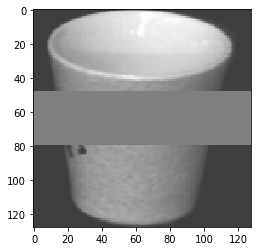

In [ ]:
# SETUP:

data = getData()
trainData = data[0]
alteredTrainData = data[1]
testData = data[2]
alteredTestData = data[3]

# Getting the nets
discriminator = Discriminator(); discriminator.cuda()
generator = Generator(); generator.cuda()

criterion = nn.BCELoss()
auxCriterion = nn.MSELoss()

d_lr = 1e-4
d_optimizer = optim.Adam(discriminator.parameters(), d_lr)#, momentum=0.6)

g_lr = 2e-3
g_optimizer = optim.SGD(generator.parameters(), g_lr)#, momentum=0.5)

pyplot.imshow(convertTo2DArray(alteredTrainData[0], [128, 128]), "gray", vmin = 0, vmax = 255)
pyplot.show()

def extract(v):
    return v.data.storage().tolist()

def notify(title, text):
    os.system("""
              osascript -e 'display notification "{}" with title "{}"'
              """.format(text, title))

		EPOCH: 0
	BatchNum: 0
D} fakeError: 0.664 realError: 0.725 lastFakeOutput: 0.515 lastRealOutput: 0.499
D} fakeError: 0.559 realError: 0.577 lastFakeOutput: 0.591 lastRealOutput: 0.407
D} fakeError: 0.501 realError: 0.48 lastFakeOutput: 0.648 lastRealOutput: 0.331
D} fakeError: 0.459 realError: 0.413 lastFakeOutput: 0.69 lastRealOutput: 0.273
G} g_mainError: 1.257 g_auxError: 0.302
G} g_mainError: 1.114 g_auxError: 0.3
G} g_mainError: 0.844 g_auxError: 0.301
G} g_mainError: 0.713 g_auxError: 0.3
G} g_mainError: 0.652 g_auxError: 0.299
G} g_mainError: 0.61 g_auxError: 0.298
G} g_mainError: 0.597 g_auxError: 0.297
G} g_mainError: 0.572 g_auxError: 0.296
G} g_mainError: 0.568 g_auxError: 0.296
G} g_mainError: 0.547 g_auxError: 0.295
	BatchNum: 1
D} fakeError: 0.7 realError: 0.672 lastFakeOutput: 0.484 lastRealOutput: 0.497
D} fakeError: 0.607 realError: 0.551 lastFakeOutput: 0.543 lastRealOutput: 0.402
D} fakeError: 0.54 realError: 0.467 lastFakeOutput: 0.592 lastRealOutput: 0.341
D} fak

G} g_mainError: 0.175 g_auxError: 0.319
G} g_mainError: 0.138 g_auxError: 0.317
G} g_mainError: 0.118 g_auxError: 0.317
G} g_mainError: 0.105 g_auxError: 0.316
G} g_mainError: 0.098 g_auxError: 0.315
G} g_mainError: 0.094 g_auxError: 0.315
	BatchNum: 12
D} fakeError: 0.465 realError: 0.493 lastFakeOutput: 0.656 lastRealOutput: 0.144
D} fakeError: 0.357 realError: 0.298 lastFakeOutput: 0.887 lastRealOutput: 0.218
D} fakeError: 0.331 realError: 0.234 lastFakeOutput: 0.934 lastRealOutput: 0.161
D broken.
G} g_mainError: 2.242 g_auxError: 0.239
G} g_mainError: 0.843 g_auxError: 0.24
G} g_mainError: 0.564 g_auxError: 0.239
G} g_mainError: 0.375 g_auxError: 0.24
G} g_mainError: 0.215 g_auxError: 0.239
G} g_mainError: 0.171 g_auxError: 0.239
G} g_mainError: 0.142 g_auxError: 0.238
G} g_mainError: 0.127 g_auxError: 0.238
G} g_mainError: 0.117 g_auxError: 0.237
G} g_mainError: 0.109 g_auxError: 0.237
	BatchNum: 13
D} fakeError: 0.518 realError: 0.373 lastFakeOutput: 0.823 lastRealOutput: 0.633


G} g_mainError: 0.394 g_auxError: 0.289
G} g_mainError: 0.223 g_auxError: 0.289
G} g_mainError: 0.137 g_auxError: 0.289
G} g_mainError: 0.107 g_auxError: 0.288
G} g_mainError: 0.094 g_auxError: 0.288
G} g_mainError: 0.084 g_auxError: 0.287
G} g_mainError: 0.076 g_auxError: 0.287
	BatchNum: 25
D} fakeError: 0.436 realError: 0.337 lastFakeOutput: 0.752 lastRealOutput: 0.122
D} fakeError: 0.337 realError: 0.221 lastFakeOutput: 0.867 lastRealOutput: 0.102
D broken.
G} g_mainError: 1.994 g_auxError: 0.273
G} g_mainError: 1.323 g_auxError: 0.276
G} g_mainError: 0.873 g_auxError: 0.276
G} g_mainError: 0.29 g_auxError: 0.277
G} g_mainError: 0.133 g_auxError: 0.276
G} g_mainError: 0.1 g_auxError: 0.276
G} g_mainError: 0.087 g_auxError: 0.275
G} g_mainError: 0.078 g_auxError: 0.275
G} g_mainError: 0.071 g_auxError: 0.274
G} g_mainError: 0.066 g_auxError: 0.274
	BatchNum: 26
D} fakeError: 0.68 realError: 0.399 lastFakeOutput: 0.744 lastRealOutput: 0.43
D} fakeError: 0.371 realError: 0.232 lastFak

G} g_mainError: 0.083 g_auxError: 0.293
G} g_mainError: 0.077 g_auxError: 0.293
	BatchNum: 38
D} fakeError: 0.433 realError: 0.597 lastFakeOutput: 0.403 lastRealOutput: 0.207
D} fakeError: 0.337 realError: 0.284 lastFakeOutput: 0.905 lastRealOutput: 0.3
D broken.
G} g_mainError: 2.05 g_auxError: 0.311
G} g_mainError: 1.435 g_auxError: 0.314
G} g_mainError: 1.082 g_auxError: 0.315
G} g_mainError: 0.448 g_auxError: 0.315
G} g_mainError: 0.214 g_auxError: 0.315
G} g_mainError: 0.149 g_auxError: 0.314
G} g_mainError: 0.124 g_auxError: 0.314
G} g_mainError: 0.109 g_auxError: 0.314
G} g_mainError: 0.1 g_auxError: 0.313
G} g_mainError: 0.092 g_auxError: 0.313
	BatchNum: 39
D} fakeError: 0.461 realError: 0.306 lastFakeOutput: 0.569 lastRealOutput: 0.064
D} fakeError: 0.332 realError: 0.217 lastFakeOutput: 0.862 lastRealOutput: 0.066
D broken.
G} g_mainError: 2.001 g_auxError: 0.303
G} g_mainError: 0.959 g_auxError: 0.305
G} g_mainError: 0.563 g_auxError: 0.304
G} g_mainError: 0.26 g_auxError: 

G} g_mainError: 0.111 g_auxError: 0.252
G} g_mainError: 0.102 g_auxError: 0.252
	BatchNum: 52
D} fakeError: 0.577 realError: 0.361 lastFakeOutput: 0.957 lastRealOutput: 0.123
D} fakeError: 0.359 realError: 0.243 lastFakeOutput: 0.928 lastRealOutput: 0.099
D} fakeError: 0.357 realError: 0.224 lastFakeOutput: 0.871 lastRealOutput: 0.072
D} fakeError: 0.376 realError: 0.22 lastFakeOutput: 0.833 lastRealOutput: 0.054
G} g_mainError: 3.253 g_auxError: 0.269
G} g_mainError: 1.695 g_auxError: 0.271
G} g_mainError: 1.145 g_auxError: 0.273
G} g_mainError: 0.527 g_auxError: 0.273
G} g_mainError: 0.287 g_auxError: 0.273
G} g_mainError: 0.172 g_auxError: 0.273
G} g_mainError: 0.138 g_auxError: 0.272
G} g_mainError: 0.12 g_auxError: 0.272
G} g_mainError: 0.109 g_auxError: 0.272
G} g_mainError: 0.1 g_auxError: 0.272
	BatchNum: 53
D} fakeError: 0.495 realError: 0.223 lastFakeOutput: 0.308 lastRealOutput: 0.01
D} fakeError: 0.338 realError: 0.208 lastFakeOutput: 0.917 lastRealOutput: 0.019
D broken.
G

G} g_mainError: 0.313 g_auxError: 0.28
G} g_mainError: 0.202 g_auxError: 0.28
G} g_mainError: 0.139 g_auxError: 0.28
G} g_mainError: 0.118 g_auxError: 0.28
G} g_mainError: 0.105 g_auxError: 0.279
G} g_mainError: 0.097 g_auxError: 0.279
	BatchNum: 65
D} fakeError: 0.459 realError: 0.585 lastFakeOutput: 0.306 lastRealOutput: 0.038
D} fakeError: 0.338 realError: 0.252 lastFakeOutput: 0.862 lastRealOutput: 0.074
D broken.
G} g_mainError: 2.344 g_auxError: 0.313
G} g_mainError: 1.137 g_auxError: 0.315
G} g_mainError: 0.912 g_auxError: 0.315
G} g_mainError: 0.449 g_auxError: 0.315
G} g_mainError: 0.238 g_auxError: 0.315
G} g_mainError: 0.14 g_auxError: 0.315
G} g_mainError: 0.114 g_auxError: 0.315
G} g_mainError: 0.1 g_auxError: 0.314
G} g_mainError: 0.091 g_auxError: 0.314
G} g_mainError: 0.085 g_auxError: 0.313
	BatchNum: 66
D} fakeError: 0.766 realError: 0.275 lastFakeOutput: 0.34 lastRealOutput: 0.023
D} fakeError: 0.36 realError: 0.209 lastFakeOutput: 0.863 lastRealOutput: 0.046
D} fake

G} g_mainError: 0.146 g_auxError: 0.293
G} g_mainError: 0.133 g_auxError: 0.293
	BatchNum: 79
D} fakeError: 0.417 realError: 0.279 lastFakeOutput: 0.863 lastRealOutput: 0.162
D} fakeError: 0.336 realError: 0.223 lastFakeOutput: 0.869 lastRealOutput: 0.077
D broken.
G} g_mainError: 1.967 g_auxError: 0.313
G} g_mainError: 1.308 g_auxError: 0.313
G} g_mainError: 1.483 g_auxError: 0.315
G} g_mainError: 0.735 g_auxError: 0.316
G} g_mainError: 0.404 g_auxError: 0.316
G} g_mainError: 0.214 g_auxError: 0.315
G} g_mainError: 0.163 g_auxError: 0.315
G} g_mainError: 0.141 g_auxError: 0.315
G} g_mainError: 0.126 g_auxError: 0.315
G} g_mainError: 0.117 g_auxError: 0.314
	BatchNum: 80
D} fakeError: 0.596 realError: 0.361 lastFakeOutput: 0.609 lastRealOutput: 0.06
D} fakeError: 0.342 realError: 0.222 lastFakeOutput: 0.802 lastRealOutput: 0.077
D broken.
G} g_mainError: 1.883 g_auxError: 0.301
G} g_mainError: 1.012 g_auxError: 0.301
G} g_mainError: 0.831 g_auxError: 0.301
G} g_mainError: 0.503 g_auxEr

G} g_mainError: 1.978 g_auxError: 0.281
G} g_mainError: 1.613 g_auxError: 0.282
G} g_mainError: 0.836 g_auxError: 0.282
G} g_mainError: 0.441 g_auxError: 0.282
G} g_mainError: 0.196 g_auxError: 0.282
G} g_mainError: 0.137 g_auxError: 0.281
G} g_mainError: 0.115 g_auxError: 0.281
G} g_mainError: 0.102 g_auxError: 0.281
G} g_mainError: 0.093 g_auxError: 0.281
	BatchNum: 93
D} fakeError: 0.577 realError: 0.233 lastFakeOutput: 0.553 lastRealOutput: 0.059
D} fakeError: 0.339 realError: 0.207 lastFakeOutput: 0.893 lastRealOutput: 0.086
D broken.
G} g_mainError: 1.996 g_auxError: 0.26
G} g_mainError: 0.864 g_auxError: 0.261
G} g_mainError: 0.407 g_auxError: 0.26
G} g_mainError: 0.239 g_auxError: 0.26
G} g_mainError: 0.155 g_auxError: 0.26
G} g_mainError: 0.122 g_auxError: 0.26
G} g_mainError: 0.105 g_auxError: 0.259
G} g_mainError: 0.095 g_auxError: 0.259
G} g_mainError: 0.088 g_auxError: 0.259
G} g_mainError: 0.082 g_auxError: 0.259
	BatchNum: 94
D} fakeError: 0.559 realError: 0.252 lastFake

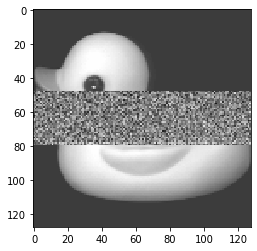

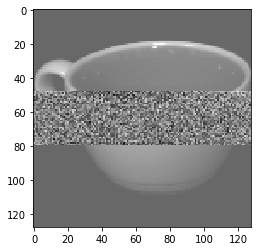

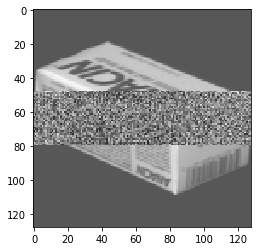

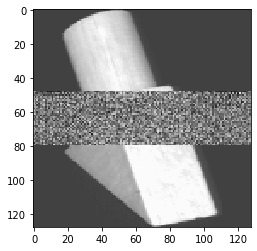

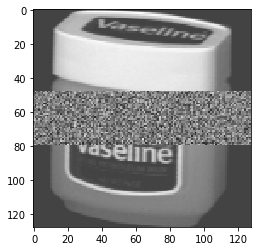

test set:


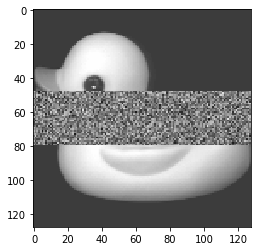

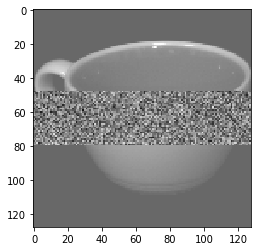

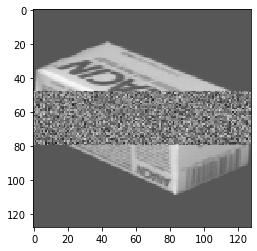

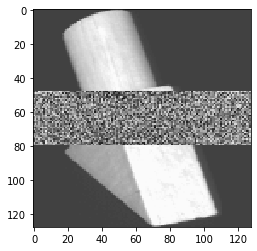

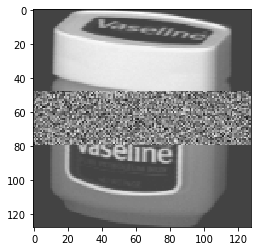

G} g_mainError: 0.111 g_auxError: 0.318
		EPOCH: 1
	BatchNum: 0
D} fakeError: 0.485 realError: 0.234 lastFakeOutput: 0.413 lastRealOutput: 0.01
D} fakeError: 0.33 realError: 0.222 lastFakeOutput: 0.916 lastRealOutput: 0.017
D broken.
G} g_mainError: 2.138 g_auxError: 0.288
G} g_mainError: 1.461 g_auxError: 0.289
G} g_mainError: 1.067 g_auxError: 0.289
G} g_mainError: 0.34 g_auxError: 0.29
G} g_mainError: 0.167 g_auxError: 0.29
G} g_mainError: 0.113 g_auxError: 0.289
G} g_mainError: 0.096 g_auxError: 0.289
G} g_mainError: 0.087 g_auxError: 0.289
G} g_mainError: 0.08 g_auxError: 0.289
G} g_mainError: 0.074 g_auxError: 0.288
	BatchNum: 1
D} fakeError: 0.597 realError: 0.241 lastFakeOutput: 0.97 lastRealOutput: 0.102
D} fakeError: 0.346 realError: 0.221 lastFakeOutput: 0.93 lastRealOutput: 0.079
D broken.
G} g_mainError: 2.147 g_auxError: 0.354
G} g_mainError: 1.229 g_auxError: 0.354
G} g_mainError: 0.791 g_auxError: 0.355
G} g_mainError: 0.374 g_auxError: 0.355
G} g_mainError: 0.184 g_aux

G} g_mainError: 0.267 g_auxError: 0.32
G} g_mainError: 0.222 g_auxError: 0.32
G} g_mainError: 0.199 g_auxError: 0.32
G} g_mainError: 0.182 g_auxError: 0.32
	BatchNum: 14
D} fakeError: 0.429 realError: 0.283 lastFakeOutput: 0.908 lastRealOutput: 0.265
D} fakeError: 0.33 realError: 0.234 lastFakeOutput: 0.905 lastRealOutput: 0.132
D broken.
G} g_mainError: 2.397 g_auxError: 0.256
G} g_mainError: 1.565 g_auxError: 0.257
G} g_mainError: 1.949 g_auxError: 0.257
G} g_mainError: 1.693 g_auxError: 0.258
G} g_mainError: 1.236 g_auxError: 0.258
G} g_mainError: 0.824 g_auxError: 0.259
G} g_mainError: 0.361 g_auxError: 0.259
G} g_mainError: 0.231 g_auxError: 0.258
G} g_mainError: 0.19 g_auxError: 0.258
G} g_mainError: 0.167 g_auxError: 0.258
	BatchNum: 15
D} fakeError: 0.489 realError: 0.331 lastFakeOutput: 0.747 lastRealOutput: 0.227
D} fakeError: 0.336 realError: 0.234 lastFakeOutput: 0.906 lastRealOutput: 0.173
D broken.
G} g_mainError: 2.26 g_auxError: 0.269
G} g_mainError: 1.509 g_auxError: 0

G} g_mainError: 0.115 g_auxError: 0.256
G} g_mainError: 0.105 g_auxError: 0.256
	BatchNum: 27
D} fakeError: 0.514 realError: 0.221 lastFakeOutput: 0.898 lastRealOutput: 0.037
D} fakeError: 0.336 realError: 0.213 lastFakeOutput: 0.932 lastRealOutput: 0.06
D broken.
G} g_mainError: 2.313 g_auxError: 0.265
G} g_mainError: 1.307 g_auxError: 0.265
G} g_mainError: 1.085 g_auxError: 0.265
G} g_mainError: 0.683 g_auxError: 0.265
G} g_mainError: 0.354 g_auxError: 0.265
G} g_mainError: 0.223 g_auxError: 0.265
G} g_mainError: 0.183 g_auxError: 0.265
G} g_mainError: 0.162 g_auxError: 0.265
G} g_mainError: 0.144 g_auxError: 0.265
G} g_mainError: 0.132 g_auxError: 0.264
	BatchNum: 28
D} fakeError: 0.459 realError: 0.42 lastFakeOutput: 0.943 lastRealOutput: 0.105
D} fakeError: 0.333 realError: 0.243 lastFakeOutput: 0.916 lastRealOutput: 0.103
D broken.
G} g_mainError: 2.29 g_auxError: 0.28
G} g_mainError: 1.523 g_auxError: 0.281
G} g_mainError: 1.085 g_auxError: 0.281
G} g_mainError: 0.636 g_auxError

G} g_mainError: 0.412 g_auxError: 0.306
G} g_mainError: 0.274 g_auxError: 0.305
G} g_mainError: 0.215 g_auxError: 0.305
G} g_mainError: 0.185 g_auxError: 0.305
G} g_mainError: 0.167 g_auxError: 0.305
G} g_mainError: 0.154 g_auxError: 0.305
G} g_mainError: 0.142 g_auxError: 0.304
	BatchNum: 41
D} fakeError: 0.62 realError: 0.303 lastFakeOutput: 0.302 lastRealOutput: 0.037
D} fakeError: 0.337 realError: 0.231 lastFakeOutput: 0.912 lastRealOutput: 0.069
D broken.
G} g_mainError: 2.189 g_auxError: 0.277
G} g_mainError: 1.426 g_auxError: 0.277
G} g_mainError: 0.925 g_auxError: 0.277
G} g_mainError: 0.439 g_auxError: 0.277
G} g_mainError: 0.267 g_auxError: 0.276
G} g_mainError: 0.206 g_auxError: 0.276
G} g_mainError: 0.176 g_auxError: 0.276
G} g_mainError: 0.156 g_auxError: 0.276
G} g_mainError: 0.144 g_auxError: 0.276
G} g_mainError: 0.132 g_auxError: 0.275
	BatchNum: 42
D} fakeError: 0.503 realError: 0.275 lastFakeOutput: 0.89 lastRealOutput: 0.011


In [ ]:
def test(imgNum):
    batches = formBatches(5)
    imgBatches = batches[0]
    batchNum = int(imgNum / 5)
    for batchIndex in range(batchNum):
        g_output = generator(imgBatches[batchIndex].to("cuda"), 5, False)
        for imgIndex in range(5):
            img = torch.cat((alteredImgBatch[imgIndex][:128 * 48],
                                          g_output[imgIndex], alteredImgBatch[imgIndex][128 * 80:]))
            img = convertTo2DArray(img, [128, 128])
            plotArray(img)
        
        
def formBatches(b_size):
    imgBatches = []
    alteredImgBatches = []

    for imgIndex in range(len(trainData)):
        if ((imgIndex + 1) % b_size == 0 and imgIndex != 0):
            batch = torch.stack(trainData[imgIndex - (b_size - 1):imgIndex + 1])
            alteredBatch = torch.stack(alteredTrainData[imgIndex - (b_size - 1):imgIndex + 1])

            imgBatches.append(batch)
            alteredImgBatches.append(alteredBatch)
        elif imgIndex == len(trainData) - 1:
            batch = torch.stack(trainData[imgIndex - ((imgIndex) % b_size):imgIndex + 1])
            alteredBatch = torch.stack(alteredTrainData[imgIndex - ((imgIndex) % b_size):imgIndex + 1])

            imgBatches.append(batch)
            alteredImgBatches.append(alteredBatch)
            
    return [imgBatches, alteredImgBatches]

# TRAINING/TESTING:

batchSize = 10
batches = formBatches(batchSize)
imgBatches = batches[0]
alteredImgBatches = batches[1]

d_fakeErrors = []
d_realErrors = []
g_errors = []
        
for epoch in range(60):
    print("\t\tEPOCH:", epoch)
    #print("memory allocated: %E (the lower the better)" % torch.cuda.memory_allocated(device=None))
    for batchNum in range(len(imgBatches)):
        print("\tBatchNum:", batchNum)
        imgBatch = imgBatches[batchNum].to("cuda") # a tensor of tensors
        alteredImgBatch = alteredImgBatches[batchNum].to("cuda") # a tensor of tensors
        d_steps = 4
        for d_iter in range(d_steps):
            d_optimizer.zero_grad()
            discriminator.zero_grad()

            g_output = generator(alteredImgBatch, batchSize, False)

            d_fakeInput = []
            for imgNum in range(batchSize):
                d_fakeInput.append(torch.cat((alteredImgBatch[imgNum][:128 * 48],
                                    g_output[imgNum], alteredImgBatch[imgNum][128 * 80:])))
            d_fakeInput = torch.stack(d_fakeInput).to("cuda")

            d_fakeOutput = discriminator(d_fakeInput, batchSize, False)

            d_fakeError = criterion(d_fakeOutput, Variable(torch.mul(torch.ones([batchSize, 1]), 0.9)).to("cuda"))
            d_fakeError.backward(retain_graph=False)


            d_realOutput = discriminator(imgBatch, batchSize, False)
            d_realError = criterion(d_realOutput, Variable(torch.mul(torch.ones([batchSize, 1]), 0.05)).to("cuda"))
            d_realError.backward(retain_graph=False)
            
            d_fakeErrors.append(d_fakeError.item())
            d_realErrors.append(d_realError.item())
            
            # error is a 0-dim tensor
            # D output is a [5, 1] tensor
            print("D} fakeError:", round(d_fakeError.item(), 3), "realError:", round(d_realError.item(), 3),
                 "lastFakeOutput:", round(d_fakeOutput[batchSize - 1][0].item(), 3),
                 "lastRealOutput:", round(d_realOutput[batchSize - 1][0].item(), 3))
            if d_fakeError < 0.35:
                print("D broken.")
                break
            d_optimizer.step()
            
        g_steps = 10
        for g_iter in range(g_steps):
            g_optimizer.zero_grad()
            generator.zero_grad()

            printImgs = False
            if batchNum == len(imgBatches) - 1 and g_iter == g_steps - 1 and imgNum == len(imgBatch) - 1:
                notify("Conv print!", "")
                printImgs = True
            
            #print(alteredImgBatch.size())
            g_output = generator(alteredImgBatch, batchSize, printImgs)
            
            """
            The way I implemented "aux loss" probably isn't the way it's done; was just an idea I had
            """
            
            correct_g = []
            for imgTensor in imgBatch:
                correct_g.append(imgTensor[128 * 48:128 * 80])
            correct_g = torch.stack(correct_g).to("cuda")
            g_auxError = auxCriterion(g_output, correct_g)
            #print("g_auxError:", g_auxError)
            #g_auxError.backward(retain_graph=True)
            
            d_fakeInput = []
            for imgNum in range(batchSize):
                d_fakeInput.append(torch.cat((alteredImgBatch[imgNum][:128 * 48],
                                              g_output[imgNum], alteredImgBatch[imgNum][128 * 80:])))
            d_fakeInput = torch.stack(d_fakeInput).to("cuda")

            if printImgs:
                print("train set:")
                for imgIndex in range(5):
                    imgTensor = convertTo2DArray(d_fakeInput[imgIndex], [128, 128])
                    plotArray(imgTensor)
                print("test set:")
                test(5)

            d_fakeOutput = discriminator(d_fakeInput, batchSize, printImgs)
            #print("d_fakeOutput size:", d_fakeOutput.size())

            g_mainError = criterion(d_fakeOutput, Variable(torch.mul(torch.ones([batchSize, 1]), 0.001)).to("cuda"))
            
            g_error = g_mainError + torch.mul(g_auxError, 1.2)
            
            g_error.backward(retain_graph=False)

            g_optimizer.step()
            
            g_errors.append(g_error.item())
            
            print("G} g_mainError:", round(g_mainError.item(), 3), "g_auxError:", round(g_auxError.item(), 3))
    
np.set_printoptions(threshold=sys.maxsize)

notify("Run finished!", "")

d_y = np.linspace(1, len(d_realErrors), len(d_realErrors))
g_y = np.linspace(1, len(g_errors), len(g_errors))

pyplot.scatter(d_y, np.asarray(d_realErrors)); pyplot.ylabel("d_realLoss"); pyplot.show()
pyplot.scatter(d_y, np.asarray(d_fakeErrors)); pyplot.ylabel("d_fakeLoss"); pyplot.show()
pyplot.scatter(g_y, np.asarray(g_errors)); pyplot.ylabel("g_loss"); pyplot.show()

print("TEST TIME")

test(25)